# Assigment 3

Content: 
- Part 1 (Call center dataset, Normal likelihood with normal-inverse-gamma prior, and log-normal HRTEM data)
- Part 2 (Stretch goal)

### HCs Appendix
- **#modeling**: All the code are based on simulations and modeling using StanCode. For the stretch goal, I created a function for measuring the prior hyper parameters given some conditions. I also modify the default Stan Model for higher convergence. 
- #heuristics: I applied Means-ends analysis to modify the default pystan default metrics (increase the adapt_delta, number of iterations) as I want higher convergence. I follow the Stan documentations on steps toward my goals (convergence), which results in the modified code.

In [0]:
# importing packages

import pystan
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

np.random.seed(2019)
%matplotlib inline

# Part 1

## 1. Call center data set — exponential likelihood with a gamma prior

In [2]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('https://docs.google.com/spreadsheets/d/e/2PACX-1vTDuQCIYts48eH8mNrw60_c5H0cjRzhwxD2OLveOaN5DnelQ99s22oU2rzRyLS0Oh1iNlEatp68fdmv/pub?gid=485723753&single=true&output=csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


In [3]:
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  
    int<lower=1> num_calls;  
    real<lower=0> call[num_calls];  
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real<lower=0> lambda;  
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    lambda ~ gamma(alpha, beta);  // prior
    for(i in 1:num_calls) {
        call[i] ~ exponential(lambda);  // likelihood function
    }
}

"""
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6dd61ab5dd02fec5575754133ad6eead NOW.


In [4]:
input_data = {
    'num_calls' : len(waiting_times_per_hour[13]),
    'call': waiting_times_per_hour[13],
    'alpha' : 1,
    'beta' : 0.25
}

# Fit the model to the data. This will generate samples from the posterior over
# all parameters of the model. 
stan_results = stan_model.sampling(data=input_data)

print(stan_results)

Inference for Stan model: anon_model_6dd61ab5dd02fec5575754133ad6eead.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda   6.35  8.2e-3   0.32   5.74   6.14   6.34   6.56   6.99   1519    1.0
lp__   324.44    0.02   0.69 322.44 324.27 324.71 324.88 324.92   2006    1.0

Samples were drawn using NUTS at Sat Oct 19 15:03:55 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Posterior 98% confidence interval over λ

In [5]:
# extract samples from stan_results
posterior_samples = stan_results.extract()
print(
    "Posterior 98% confidence interval for lambda:",
    # percentile using numpy
    np.percentile(posterior_samples['lambda'], [1, 99]))

Posterior 98% confidence interval for lambda: [5.6352548  7.14216347]


### Histogram of posterior λ samples

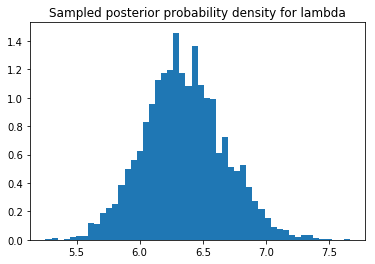

In [6]:
# Plot using matplotlib
plt.hist(posterior_samples['lambda'], bins=50, density=True)
plt.title('Sampled posterior probability density for lambda')
plt.show()

### The likelihood function for the expected λ on top of the data histogram

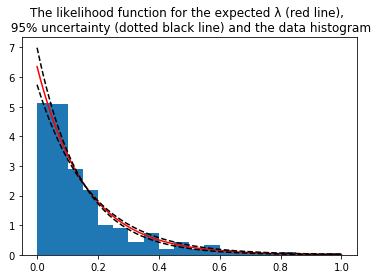

In [7]:
# Plot the likelihood function for the expected λ on top of the data histogram

# plot the mean + the 95% uncertainty of lambda
lambda_1 = np.mean(posterior_samples['lambda'])
lambda_2 = np.percentile(posterior_samples['lambda'], 2.5)
lambda_3 = np.percentile(posterior_samples['lambda'], 97.5)
x = np.linspace(0, max(waiting_times_per_hour[13]), 200)
y_1 = sts.expon.pdf(x, scale=1/lambda_1)
y_2 = sts.expon.pdf(x, scale=1/lambda_2)
y_3 = sts.expon.pdf(x, scale=1/lambda_3)
plt.plot(x, y_1, color = "red")
plt.plot(x, y_2, color = "black", linestyle = "--")
plt.plot(x, y_3, color = "black", linestyle = "--")

# histogram of data
plt.hist(waiting_times_per_hour[13], bins=20, density=True)

# title
plt.title('The likelihood function for the expected λ (red line), \n 95% uncertainty (dotted black line) and the data histogram')
plt.show()

## 2. Normal likelihood with normal-inverse-gamma prior

In [8]:
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  
    int<lower=1> num_data;  // number of data
    real ndata[num_data];  // data
    real<lower=0> mu;  // fixed prior hyperparameter
    real<lower=0> nu;   // fixed prior hyperparameter
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real<lower=0> sigma;
    real<lower=0> mean_;
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    // The normal inverse gamma is: variance sampled from a inv_gamma dist.
    // And the mean is sampled from a normal dist.
    sigma ~ inv_gamma(alpha, beta);   // variance
    mean_ ~ normal(mu, sqrt(sigma/nu));   // mean
    for(i in 1:num_data) {
        ndata[i] ~ normal(mean_, sqrt(sigma));  // likelihood function
    }
}

"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_422b92d0cd90b5cf9ef56036ee0fbea9 NOW.


In [9]:
data = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])
print(len(data), "data")

200 data


In [10]:
# priors taken from the prompt
input_data = {
    'num_data' : len(data),
    'ndata': data,
    'mu' : 0,
    'nu' : 0.054,
    'alpha': 1.12,
    'beta': 0.4
}

stan_results = stan_model.sampling(data=input_data)
print(stan_results)

Inference for Stan model: anon_model_422b92d0cd90b5cf9ef56036ee0fbea9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma   3.62  6.6e-3   0.36   2.98   3.37    3.6   3.86   4.39   2932    1.0
mean_   3.06  2.5e-3   0.13    2.8   2.97   3.06   3.15   3.32   2919    1.0
lp__  -232.1    0.02   0.96 -234.7 -232.4 -231.8 -231.4 -231.1   1798    1.0

Samples were drawn using NUTS at Sat Oct 19 15:05:08 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [0]:
# extract samplings data from stan_results
posterior_samples = stan_results.extract()


### 95% posterior confidence intervals for the μ and variance σ of the log-transformed data

In [12]:
# sample (With replacement) 1000000 samples from posterior_samples
sample_sigma = np.random.choice(posterior_samples['sigma'], 1000000)
sample_mean_ = np.random.choice(posterior_samples['mean_'], 1000000)

# compute confidence intervals
print('95% prior confidence intervals:')
print('x: [%.3f, %.3f]' % (
    np.percentile(sample_mean_, 2.5),
    np.percentile(sample_mean_, 97.5)))
print('σ²: [%.3f, %.3f]' % (
    np.percentile(sample_sigma, 2.5),
    np.percentile(sample_sigma, 97.5)))

95% prior confidence intervals:
x: [2.804, 3.324]
σ²: [2.987, 4.395]


### Take 10 samples from your posterior over μ and σ and plot the log-normal distributions corresponding to them

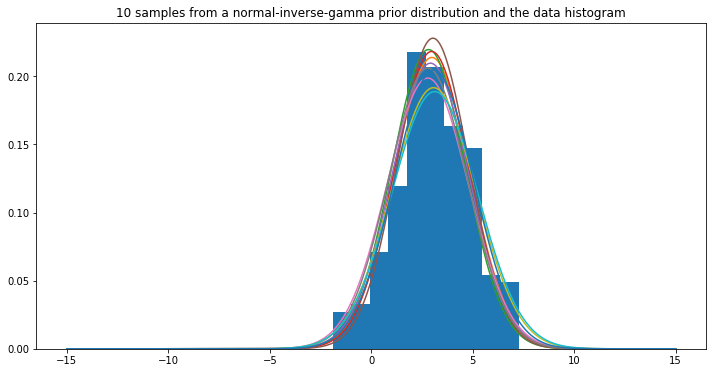

In [13]:
# take 10 samples
sigma_items = np.random.choice(posterior_samples['sigma'], 10)
mean__items = np.random.choice(posterior_samples['mean_'], 10)
plt.figure(figsize=(12, 6))
# plot histogram
plt.hist(data, density = True)

# plot 10 samples

plot_x = np.linspace(-15, 15, 500)
num_samples = 10
for i in range(num_samples):
    plot_y = sts.norm.pdf(plot_x, loc=mean__items[i], scale=np.sqrt(sigma_items[i]))
    plt.plot(plot_x, plot_y)
plt.title('%i samples from a normal-inverse-gamma prior distribution and the data histogram' % num_samples)
plt.show()

## 3. Log-normal HRTEM data. 

In [0]:
# load data
data = np.loadtxt('https://course-resources.minerva.kgi.edu/uploaded_files/mke/00075398-1635/hrtem.csv')

In [15]:
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  
    int<lower=1> num_data;  // number of data
    real ndata[num_data];  // data
    real<lower=0> mu;  // fixed prior hyperparameter
    real<lower=0> nu;   // fixed prior hyperparameter
    real<lower=0> alpha; // fixed prior hyperparameter
    real<lower=0> beta;  // fixed prior hyperparameter
}

// create log_data within the stancode
transformed data {
    real ldata[num_data];
    for (n in 1:num_data)
      ldata[n] <- log(ndata[n]);
}
// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real<lower=0> sigma;  // variance
    real mean_;  // mean
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {

    sigma ~ inv_gamma(alpha, beta);  # variance from inv_gamma dist.
    mean_ ~ normal(mu, sqrt(sigma/nu));  # mean from a normal dist.
    for(i in 1:num_data) {
        ldata[i] ~ normal(mean_, sqrt(sigma));  // likelihood function
    }
}

"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9b49aadd366a9743df1a60e22a1dbb22 NOW.


In [16]:
# prior hyperparameters from the prompt

input_data = {
    'num_data' : len(data),
    'ndata': data,
    'mu' : 2.3,
    'nu' : 0.1,
    'alpha': 2,
    'beta': 5
}

stan_results = stan_model.sampling(data=input_data)
print(stan_results)

Inference for Stan model: anon_model_9b49aadd366a9743df1a60e22a1dbb22.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma    0.5  5.3e-4   0.03   0.44   0.47   0.49   0.52   0.56   3545    1.0
mean_   1.89  5.2e-4   0.03   1.83   1.87   1.89   1.91   1.95   3683    1.0
lp__  -76.04    0.02    1.0 -78.67 -76.45 -75.74 -75.32 -75.04   1698    1.0

Samples were drawn using NUTS at Sat Oct 19 15:06:21 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [0]:
# extract samples from stan_results
posterior_samples = stan_results.extract()

### 95% posterior confidence intervals for the μ and variance σ of the log-transformed data

In [18]:
# random sample (With replacement) from the posterior samples
sample_sigma = np.random.choice(posterior_samples['sigma'], 1000000)
sample_mean_ = np.random.choice(posterior_samples['mean_'], 1000000)

# compute percentile
print('95% prior confidence intervals:')
print('x: [%.3f, %.3f]' % (
    np.percentile(sample_mean_, 2.5),
    np.percentile(sample_mean_, 97.5)))
print('σ²: [%.3f, %.3f]' % (
    np.percentile(sample_sigma, 2.5),
    np.percentile(sample_sigma, 97.5)))

95% prior confidence intervals:
x: [1.832, 1.954]
σ²: [0.437, 0.562]


### Take 10 samples from your posterior over μ and σ and plot the log-normal distributions corresponding to them

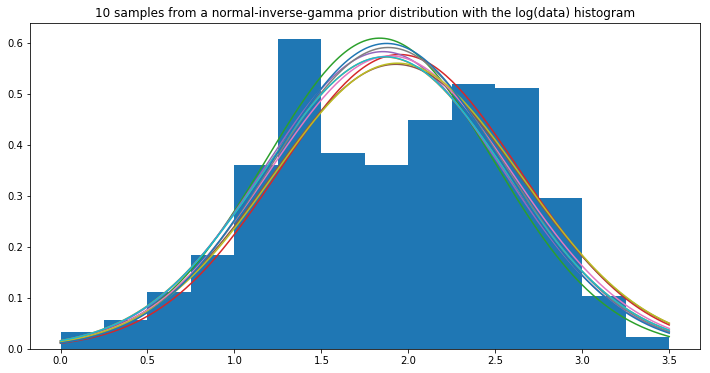

In [19]:
sigma_items = np.random.choice(posterior_samples['sigma'], 10)
mean__items = np.random.choice(posterior_samples['mean_'], 10)


plt.figure(figsize=(12, 6))

#plot histogram
plt.hist(np.log(data), bins=np.linspace(0, 3.5, 15), density = True)

# plot the lines
plot_x = np.linspace(0, 3.5, 200)
num_samples = 10
for i in range(num_samples):
    plot_y = sts.norm.pdf(plot_x, loc=mean__items[i], scale=np.sqrt(sigma_items[i]))
    plt.plot(plot_x, plot_y)
plt.title('%i samples from a normal-inverse-gamma prior distribution with the log(data) histogram' % num_samples)
plt.show()

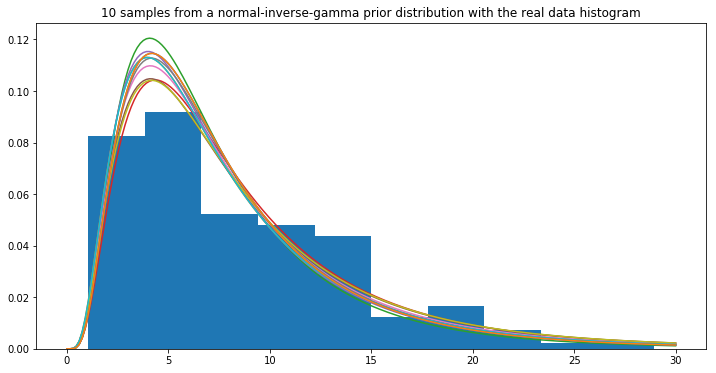

In [20]:
plt.figure(figsize=(12,6))

# plot histogram
plt.hist(data, density = True)

# plot the line
plot_x = np.linspace(0, 30, 200)
num_samples = 10
for i in range(num_samples):
    plot_y = sts.lognorm.pdf(plot_x, np.sqrt(sigma_items[i]), scale=np.exp(mean__items[i]))
    plt.plot(plot_x, plot_y)
plt.plot(plot_x, plot_y)
plt.title('%i samples from a normal-inverse-gamma prior distribution with the real data histogram' % num_samples)
plt.show()

# Part 2: Stretch goal

In [0]:
data = np.loadtxt('https://course-resources.minerva.kgi.edu/uploaded_files/mke/00075398-1635/hrtem.csv')

## Reasoning: 
**Prior distribution:** We think this data can be a combination of 2 normal distribution. Call the mean and variance of both distribution ${\chi}_1, {\sigma}_1$ and ${\chi}_2, {\sigma}_2$

The error margins given below represent 1 standard deviation from the mean of the parameter: 

We suspect that
- ${\chi}_1$ is approximately 5 ± 1
- ${\sigma}_1$ is approximately 2 ± 1
- ${\chi}_2$ is approximately 11 ± 2
- ${\sigma}_2$ is approximately 4 ± 2
- ${\chi}_1, {\sigma}_1$ is sampled from the normal-inverse-gamma distribution with parameters - ${\alpha}_1, \beta_1, \mu_1, \nu_1$
- ${\chi}_2, {\sigma}_2$ is sampled from the normal-inverse-gamma distribution with parameters - ${\alpha}_2, \beta_2, \mu_2, \nu_2$

### A function to find the hyperparameters 

As $\chi, \sigma$ follows a normal-inverse-gamma distribution of $({\alpha}, \beta, \mu, \nu)$: 

$\chi$ has the mean $a$ and standard deviation $b$; $\sigma$ has the mean $c$ and standard deviation $d$

$mean(\chi) = a$

$\Rightarrow \mu = a  \qquad (1)$

$var(\chi) = b^2 \qquad$ (because $b$ is the standard deviation)  

$\Rightarrow \frac{\beta}{(\alpha-1)\nu} = b^2  \qquad (2)$ 

$mean(\sigma) = c$

$\Rightarrow \frac{\beta}{\alpha-1} = c  \qquad (3)$

$var(\sigma) = d^2  \qquad$ (because $d$ is the standard deviation) 

$\Rightarrow \frac{\beta^2}{(\alpha-1)^2(\alpha-2)} = d^2 \qquad (4)$

$$$$

From $(1)\Rightarrow \mu = a$

From $(2),(3) \Rightarrow \nu = \frac{c}{b^2}$

From $(3),(4) \Rightarrow \alpha = \frac{c^2}{d^2} + 2$

From $(3) \Rightarrow \beta = c*(\alpha-1)$

In [0]:
def find_para(a,b,c,d):
  mu = a
  nu = c/b**2
  alpha = c**2/d**2 + 2
  beta = c*(alpha-1)
  return alpha, beta, mu, nu

In [34]:
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  
    int<lower=1> num_data;  
    real ndata[num_data]; 
    real<lower=0> mu_1;  
    real<lower=0> nu_1;  
    real<lower=0> alpha_1;  
    real<lower=0> beta_1;   
    real<lower=0> mu_2;
    real<lower=0> nu_2;
    real<lower=0> alpha_2;  
    real<lower=0> beta_2;   
}
// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real <lower = 0, upper = 1> p;
    real<lower=0> mean_1;
    real<lower=0> sigma_1;
    real<lower=0> mean_2;
    real<lower=0> sigma_2;
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.


model {
    p ~ uniform(0,1);
    sigma_1 ~ inv_gamma(alpha_1, beta_1); 
    mean_1 ~ normal(mu_1, sqrt(sigma_1/nu_1));
    sigma_2 ~ inv_gamma(alpha_2, beta_2); 
    mean_2 ~ normal(mu_2, sqrt(sigma_2/nu_2));
    for (i in 1:num_data){
      target += p*normal_lpdf(ndata[i] | mean_1, sqrt(sigma_1)) + (1-p)*normal_lpdf(ndata[i] | mean_2, sqrt(sigma_2));
    }
    
}
"""

input_data = {
    'num_data' : len(data),
    'ndata': data,
    'alpha_1' : find_para(5,1,2,1)[0],
    'beta_1' : find_para(5,1,2,1)[1],
    'mu_1' : find_para(5,1,2,1)[2],
    'nu_1' : find_para(5,1,2,1)[3],
    'alpha_2' : find_para(11,2,4,2)[0],
    'beta_2' : find_para(11,2,4,2)[1],
    'mu_2' : find_para(11,2,4,2)[2],
    'nu_2' : find_para(11,2,4,2)[3],
}

control = {}
control['max_treedepth'] = 20
control['adapt_delta'] = 0.99
stan_model = pystan.stan(model_code=stan_code, data = input_data, iter=10000, chains=10, warmup=2000, control = control)

stan_model

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ab6fb997c407dffab853a98c07f04768 NOW.


Inference for Stan model: anon_model_ab6fb997c407dffab853a98c07f04768.
10 chains, each with iter=10000; warmup=2000; thin=1; 
post-warmup draws per chain=8000, total post-warmup draws=80000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p       6.0e-3  3.3e-3   0.07 6.4e-6 7.8e-5 2.0e-4 4.7e-4 2.5e-3    485   1.04
mean_1    5.27    0.01   1.16   3.06   4.54   5.24   5.97   7.78  10237    1.0
sigma_1   2.88    0.09   2.74    1.0   1.66   2.27   3.23   7.89    889   1.02
mean_2    8.31  5.3e-3   0.29   7.82   8.14    8.3   8.47   8.79   2986   1.01
sigma_2  29.18    0.08   2.46  25.78  27.99  29.19  30.47  33.12   1069   1.02
lp__     -1598    0.01   1.73  -1602  -1599  -1597  -1596  -1595  18791    1.0

Samples were drawn using NUTS at Sat Oct 19 15:47:22 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [0]:
posterior_samples = stan_model.extract()

### Confidence Intervals and plot the histogram of parameters p

95% prior confidence intervals:
p: [0.000, 0.003]


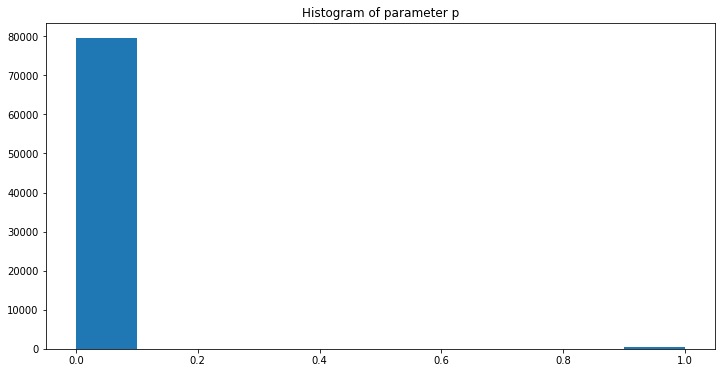

In [36]:
# compute percentile
plt.figure(figsize=(12,6))
print('95% prior confidence intervals:')
print('p: [%.3f, %.3f]' % (
    np.percentile(posterior_samples['p'], 2.5),
    np.percentile(posterior_samples['p'], 97.5)))

plt.hist(posterior_samples['p'])
plt.title("Histogram of parameter p")
plt.show()

### Confidence Intervals and plot the histogram of parameters $\chi_1$

95% prior confidence intervals:
χ1: [3.061, 7.777]


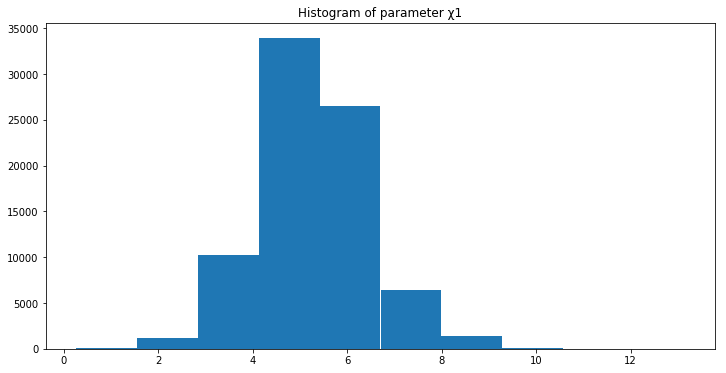

In [37]:
# compute percentile
plt.figure(figsize=(12,6))
print('95% prior confidence intervals:')
print('χ1: [%.3f, %.3f]' % (
    np.percentile(posterior_samples['mean_1'], 2.5),
    np.percentile(posterior_samples['mean_1'], 97.5)))

plt.hist(posterior_samples['mean_1'])
plt.title("Histogram of parameter χ1")
plt.show()

### Confidence Intervals and plot the histogram of parameters $\sigma_1$

95% prior confidence intervals:
σ1: [1.000, 7.890]


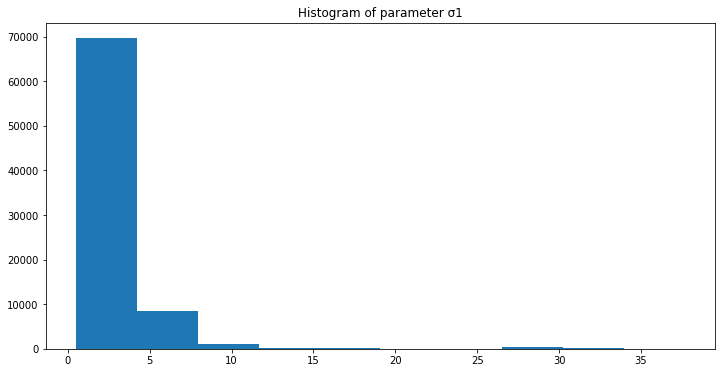

In [38]:
# compute percentile
print('95% prior confidence intervals:')
print('σ1: [%.3f, %.3f]' % (
    np.percentile(posterior_samples['sigma_1'], 2.5),
    np.percentile(posterior_samples['sigma_1'], 97.5)))
plt.figure(figsize=(12,6))
plt.hist(posterior_samples['sigma_1'])
plt.title("Histogram of parameter σ1")
plt.show()

### Confidence Intervals and plot the histogram of parameters $\chi_2$

95% prior confidence intervals:
χ2: [7.824, 8.789]


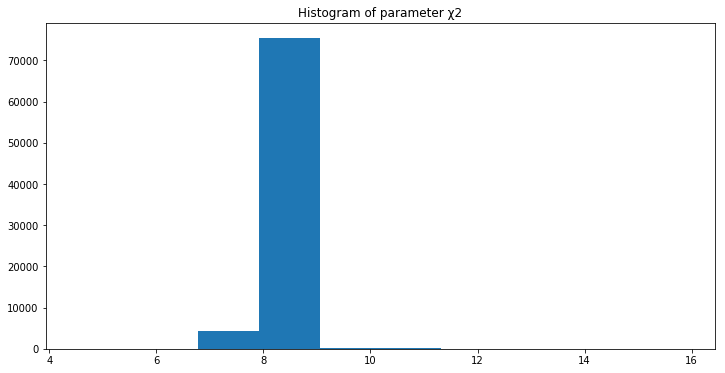

In [39]:
# compute percentile
print('95% prior confidence intervals:')
print('χ2: [%.3f, %.3f]' % (
    np.percentile(posterior_samples['mean_2'], 2.5),
    np.percentile(posterior_samples['mean_2'], 97.5)))
plt.figure(figsize=(12,6))
plt.hist(posterior_samples['mean_2'])
plt.title("Histogram of parameter χ2")
plt.show()

### Confidence Intervals and plot the histogram of parameters $\sigma_2$

95% prior confidence intervals:
σ2: [25.782, 33.121]


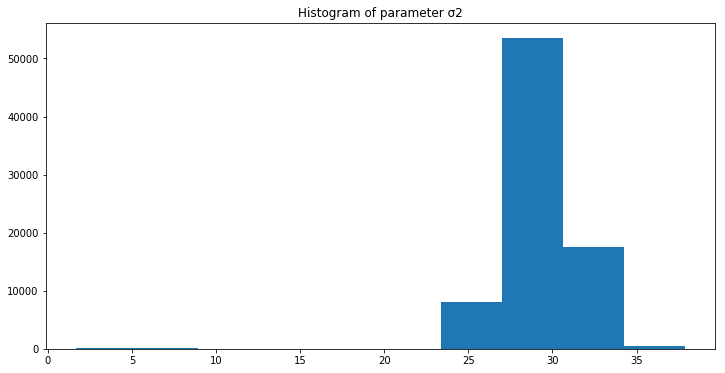

In [40]:
# compute percentile
print('95% prior confidence intervals:')
print('σ2: [%.3f, %.3f]' % (
    np.percentile(posterior_samples['sigma_2'], 2.5),
    np.percentile(posterior_samples['sigma_2'], 97.5)))
plt.figure(figsize=(12,6))
plt.hist(posterior_samples['sigma_2'])
plt.title("Histogram of parameter σ2")
plt.show()

### Plot the likelihood function on top of the data histogram 

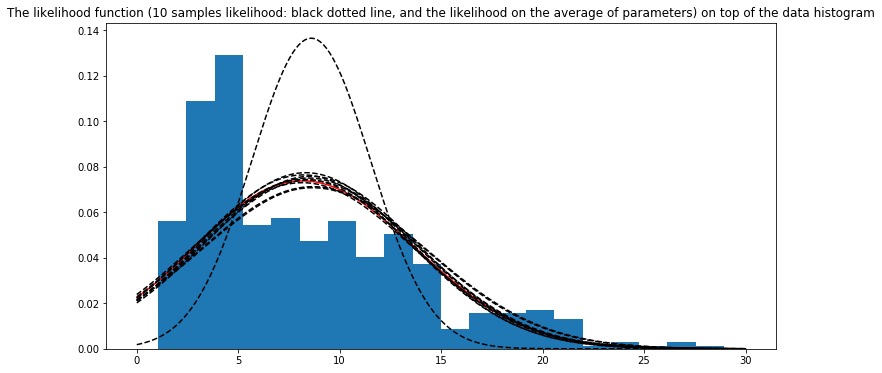

In [42]:
# Plot the likelihood function on top of the data histogram
# 10 random parameters samples of this distribution
p_items = np.random.choice(posterior_samples['p'], 10)
mean_1_items = np.random.choice(posterior_samples['mean_1'], 10)
sigma_1_items = np.random.choice(posterior_samples['sigma_1'], 10)
mean_2_items = np.random.choice(posterior_samples['mean_2'], 10)
sigma_2_items = np.random.choice(posterior_samples['sigma_2'], 10)

# The average parameters values
p_mean = np.mean(posterior_samples['p'])
mean_1_mean = np.mean(posterior_samples['mean_1'])
sigma_1_mean = np.mean(posterior_samples['sigma_1'])
mean_2_mean = np.mean(posterior_samples['mean_2'])
sigma_2_mean = np.mean(posterior_samples['sigma_2'])
plt.figure(figsize=(12,6))
# plot histogram
plt.hist(data, bins=20, density=True)

# plot the other lines:
x = np.linspace(0, 30, 200)
y = (p_mean)*sts.norm.pdf(x, loc = mean_1_mean, scale = np.sqrt(sigma_1_mean)) + (1-p_mean)*sts.norm.pdf(x, loc = mean_2_mean, scale = np.sqrt(sigma_2_mean))
plt.plot(x, y, color = "red")

for i in range(10):  
  y = (p_items[i])*sts.norm.pdf(x, loc = mean_1_items[i], scale = np.sqrt(sigma_1_items[i])) + (1-p_items[i])*sts.norm.pdf(x, loc = mean_2_items[i], scale = np.sqrt(sigma_2_items[i]))
  plt.plot(x, y, color = "black", linestyle = "--")

plt.title("The likelihood function (10 samples likelihood: black dotted line, and the likelihood on the average of parameters) on top of the data histogram")
plt.show()

## Comments: 

For the original StanModel, it diverges a lot. To fix that, I changed the number of iterations to 10000, increase the chains length, and most important, the adapt_delta (from 0.8 to 0.99), which allow the stan diagnostic to be reliable. The diagnostic of the modified stan model is reliable but not extremely, with parameters ($p, \sigma_1, \sigma_2$) with lown\_eff (crude measure of effective sample size) (there are 3 parameters have n_eff > 1000 but not all. The remaining parameters still have n_eff > 100, which is decently good). The Rhat are in range [0.9,1.1], which indicates the majority samples converges. However, the Rhat of $p, \sigma_1, \sigma_2$ are slightly further away from 1 than $\chi_1, \chi_2$ , which indicates higher chance for divergence. 

When we look at the histogram, while $\chi_1, \chi_2$ have only 1 peak, the $p, \sigma_1, \sigma_2$ are bimodel (2 peaks), which also indicates possible divergence. And this is confirmed again with the final plot, which we can see among the convergenced lines (black dotted lines near the red lines), there are outliers (the one peaked at 3).

Overall, the diagnostic shows that it does converge to some extent, which show that the modified versions worked better. However, complete convergence is not guaranteed and the results is not completely reliable.

These models (where if the mode is $\theta' = (p', \mu_1', \mu_2', \sigma_1', \sigma_2')$, it can also be equivalent to $\theta'' = (1-p', \mu_2', \mu_1', \sigma_2', \sigma_1')$). Models like this can mess up sampling-based tools like Stan, which is proven through the graphs. 


#### Additional Comments: 
(only to note to myself to ask this question once the assignments are finalized)
Unsure of having too many parameters, or because the model is tricky, but this stan_code is affected by priors. Usually the choice of priors does not affect much of the posterior (especially when we have many data points (500 points). For this case, choosing different priors can affect the convergence.